Restarted aspire (Python 3.8.18)

In [1]:
import aspire
import numpy as np
import pandas as pd
from aspire.operators import RadialCTFFilter
from aspire.source.simulation import Simulation
from aspire.volume import LegacyVolume, Volume
from utils import volsCovarEigenvec
import time
from covar_estimation import im_stack_backward
import torch
# Specify parameters
img_size = 101  # image size in square
num_imgs = 2000  # number of images
dtype = np.float32

rank = 4
c = rank + 1
vols = LegacyVolume(
    L=img_size,
    C=c,
    dtype=dtype,
).generate()
vols -= np.mean(vols,axis=0)
sim = Simulation(
    #unique_filters=[RadialCTFFilter(defocus=d) for d in np.linspace(1.5e4, 2.5e4, 7)],
    n=num_imgs,
    vols=vols,
    dtype=dtype,
    amplitudes=1,
    offsets = 0
)

vectorsGD = torch.tensor(volsCovarEigenvec(vols),requires_grad = False)


2024-04-13 11:47:55,060 INFO [aspire.source.image] Creating Simulation with 2000 images.


In [55]:
%load_ext autoreload
%autoreload 2

from covar_sgd import CovarDataset,Covar,CovarTrainer
cds = CovarDataset(sim,vectorsGD = vectorsGD)
covar = Covar(resolution=img_size,rank=rank,vectors=vectorsGD.reshape((rank,img_size,img_size,img_size))/cds.im_norm_factor)
batch_size = 1
learning_rate = 1e-4 
momentum = 0.9
reg = 1e-5
gamma_lr = 0.8
gamma_reg = 1
kwargs_dict = {'max_epochs' : 10, 'lr' : learning_rate,'momentum' : momentum,'optim_type' : 'SGD','reg' : reg,'gamma_lr': gamma_lr,'gamma_reg' : gamma_reg}
#kwargs_dict = {'max_epochs' : 10, 'lr' : 1e-10,'momentum' : momentum,'optim_type' : 'Adam','reg' : reg,'gamma_lr': gamma_lr,'gamma_reg' : gamma_reg}
device = torch.device('cuda:0')
dataloader = torch.utils.data.DataLoader(cds,batch_size = batch_size,shuffle = False)#,collate_fn=dataset_collate)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
torch.manual_seed(0)
from covar_distributed import trainParallel

trainParallel(covar,cds,num_gpus = 8,batch_size = batch_size,**kwargs_dict)



Batch size is not a multiple of number of GPUs used, increasing batch size to 8


Epoch 0 , cost value : 6.51e-01,  cosine sim : 1.00, frobenium norm error : 6.51e-03:   4%|▍         | 11/250 [00:00<00:14, 16.49it/s]

(11, tensor(2.8760e+10, device='cuda:7', grad_fn=<MeanBackward1>), tensor(0.7940, device='cuda:7'), tensor(1744.6482, device='cuda:7'), tensor(450.6679, device='cuda:7'), tensor(0.8489, device='cuda:7'), tensor(608.9547, device='cuda:7'))
tensor(430.5963, device='cuda:7')
tensor([[ 2.8309,  2.8036,  2.7764,  ..., -2.7764, -2.8036, -2.8309],
        [-1.8112, -1.7556, -1.6999,  ...,  1.6999,  1.7556,  1.8112],
        [-2.8383, -2.8328, -2.8273,  ...,  2.8273,  2.8328,  2.8383]],
       device='cuda:7')
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3467487/4166124735.py", line 4, in <module>
    trainParallel(covar,cds,num_gpus = 8,batch_size = batch_size,**kwargs_dict)
  File "/scratch/home/roaiyadgar/thesis/covar_distributed.py", line 44, in trainParallel
    mp.spawn(ddp_train,args=(num_gpus,covar_model,dataset,batch_size_per_gpu,savepath,kwargs),nprocs = num_gpus)
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/torch/multiprocessing/spawn.py", line 241, in spawn
    return start_processes(fn, args, nprocs, join, daemon, start_method="spawn")
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/torch/multiprocessing/spawn.py", line 197, in start_processes
    while not context.join():
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib

In [45]:
torch.manual_seed(0)
trainer = CovarTrainer(covar,dataloader,device)
trainer.train(**kwargs_dict)

Epoch 0 , cost value : 7.70e-01,  cosine sim : 0.82, frobenium norm error : 7.73e-01: 100%|██████████| 2000/2000 [01:42<00:00, 19.55it/s]
Epoch 1 , cost value : 3.11e-01,  cosine sim : 0.83, frobenium norm error : 7.27e-01:   4%|▎         | 70/2000 [00:03<01:31, 21.10it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3467487/2608136453.py", line 3, in <module>
    trainer.train(**kwargs_dict)
  File "/scratch/home/roaiyadgar/thesis/covar_sgd.py", line 137, in train
    self.run_epoch(epoch)
  File "/scratch/home/roaiyadgar/thesis/covar_sgd.py", line 101, in run_epoch
    pts_rot = pts_rot.to(self.device)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1396, in structured_traceback
    return 

In [ ]:
%load_ext autoreload
%autoreload 2
from covar_analyzer import CovarAnalyzer
import torch
c = CovarAnalyzer.load('data/tmp2/results.csv')

#c.plotCosineSim()
#c.plotWeightedCosineSim()
c.plotFroErr()




Epoch 1 , cost value : 1.29e+00,  cosine sim : 0.83, frobenium norm error : 7.39e-01:  10%|▉         | 199/2000 [18:37<2:48:38,  5.62s/it]
Epoch 1 , cost value : 3.11e-01,  cosine sim : 0.83, frobenium norm error : 7.27e-01:   4%|▎         | 71/2000 [04:26<2:00:49,  3.76s/it]


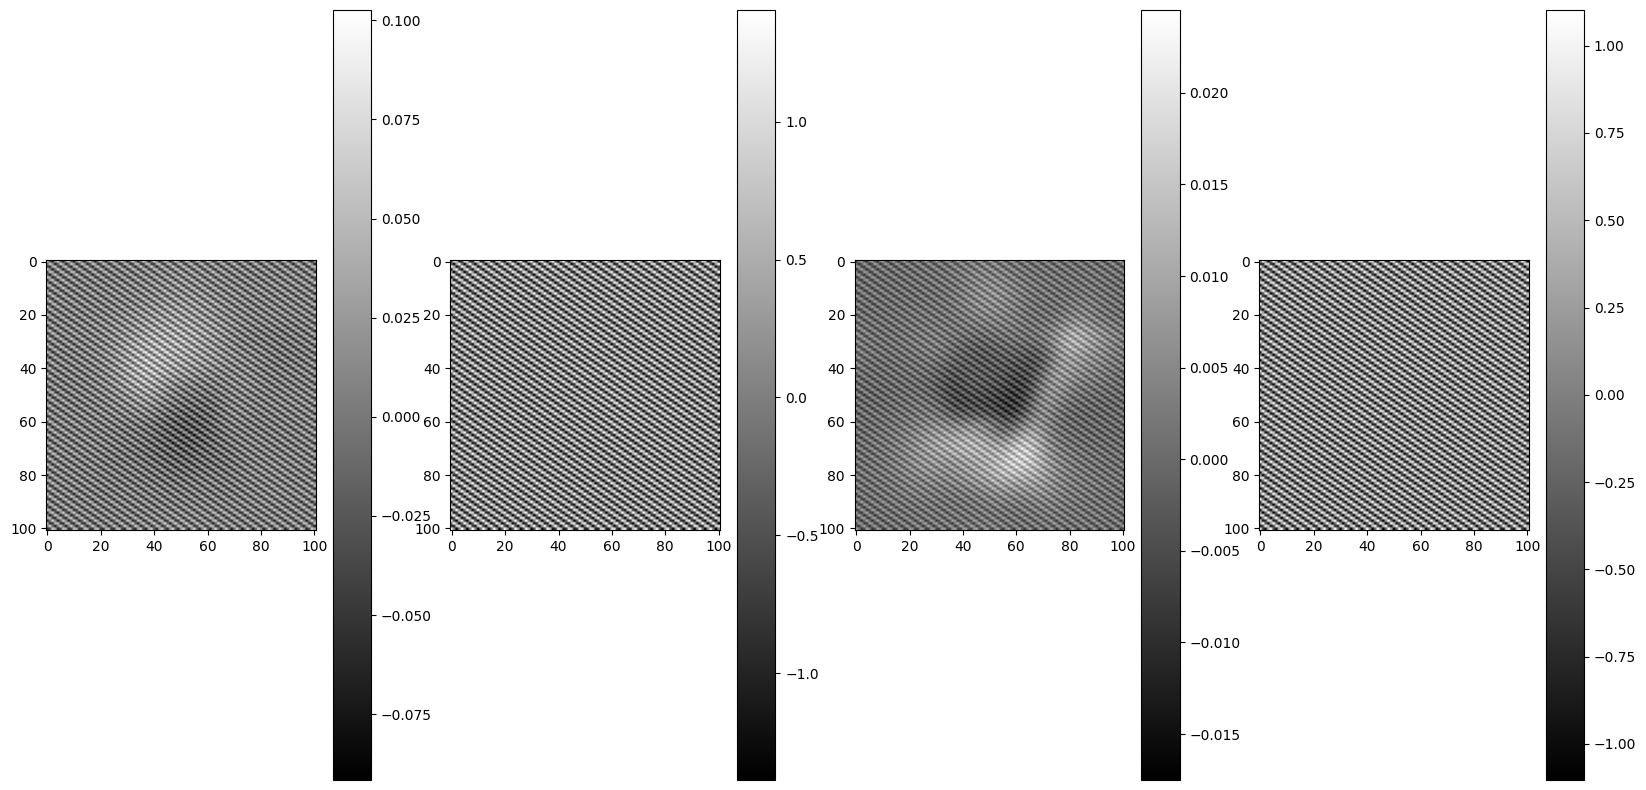

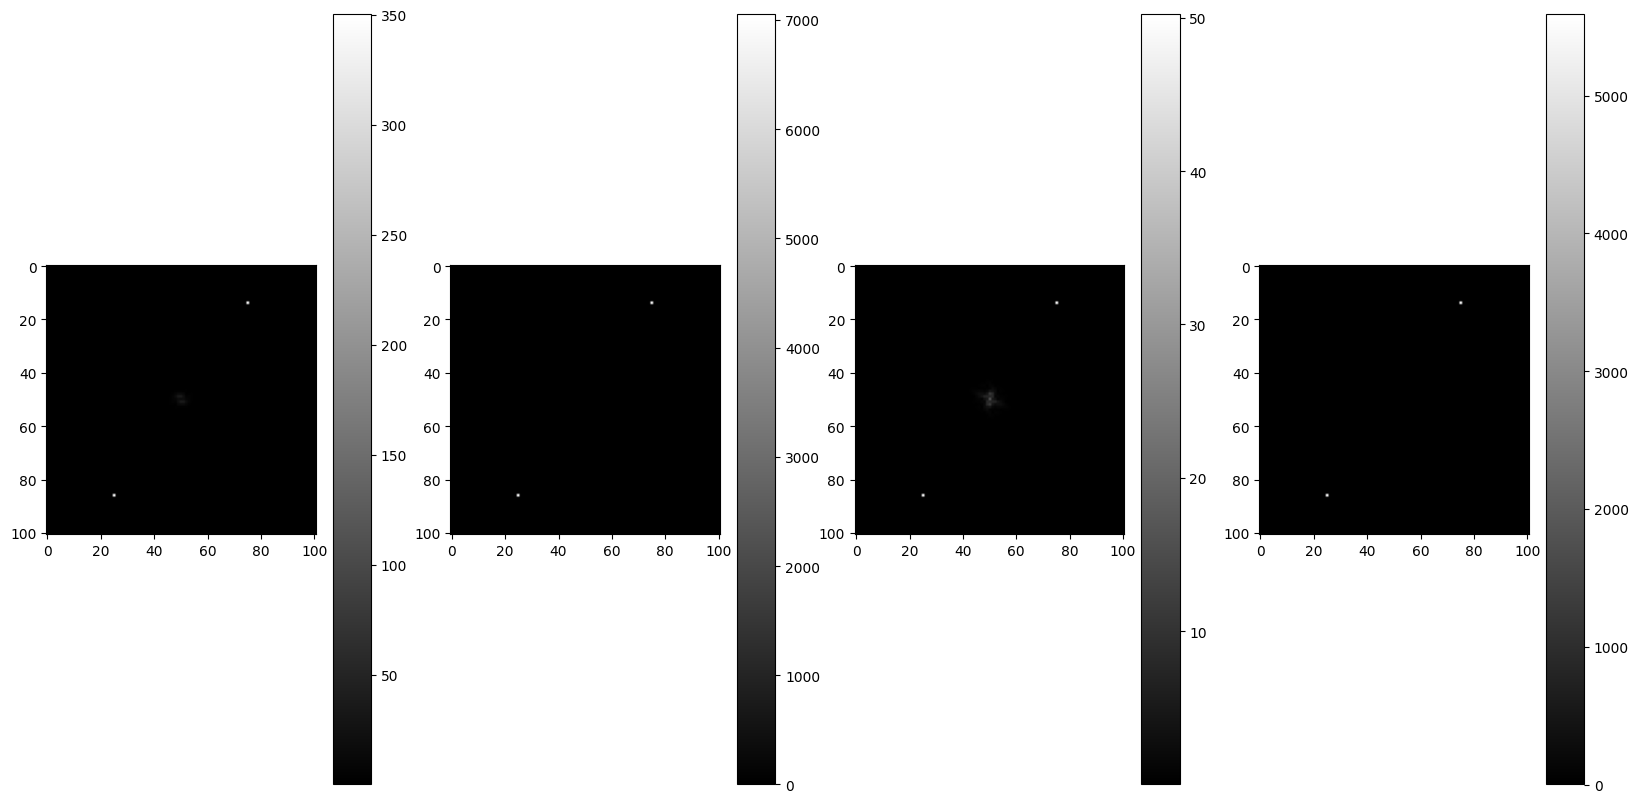

In [52]:
import pickle
from projection_funcs import centered_fft2,vol_forward
x = pickle.load(open('data/pts.bin','rb'))
projs = x['projs'][0].reshape((rank,img_size,img_size))
fft_projs = aspire.image.Image(np.abs(centered_fft2(torch.tensor(projs)).numpy()))
projs = aspire.image.Image(projs)


projs.show()
fft_projs.show()

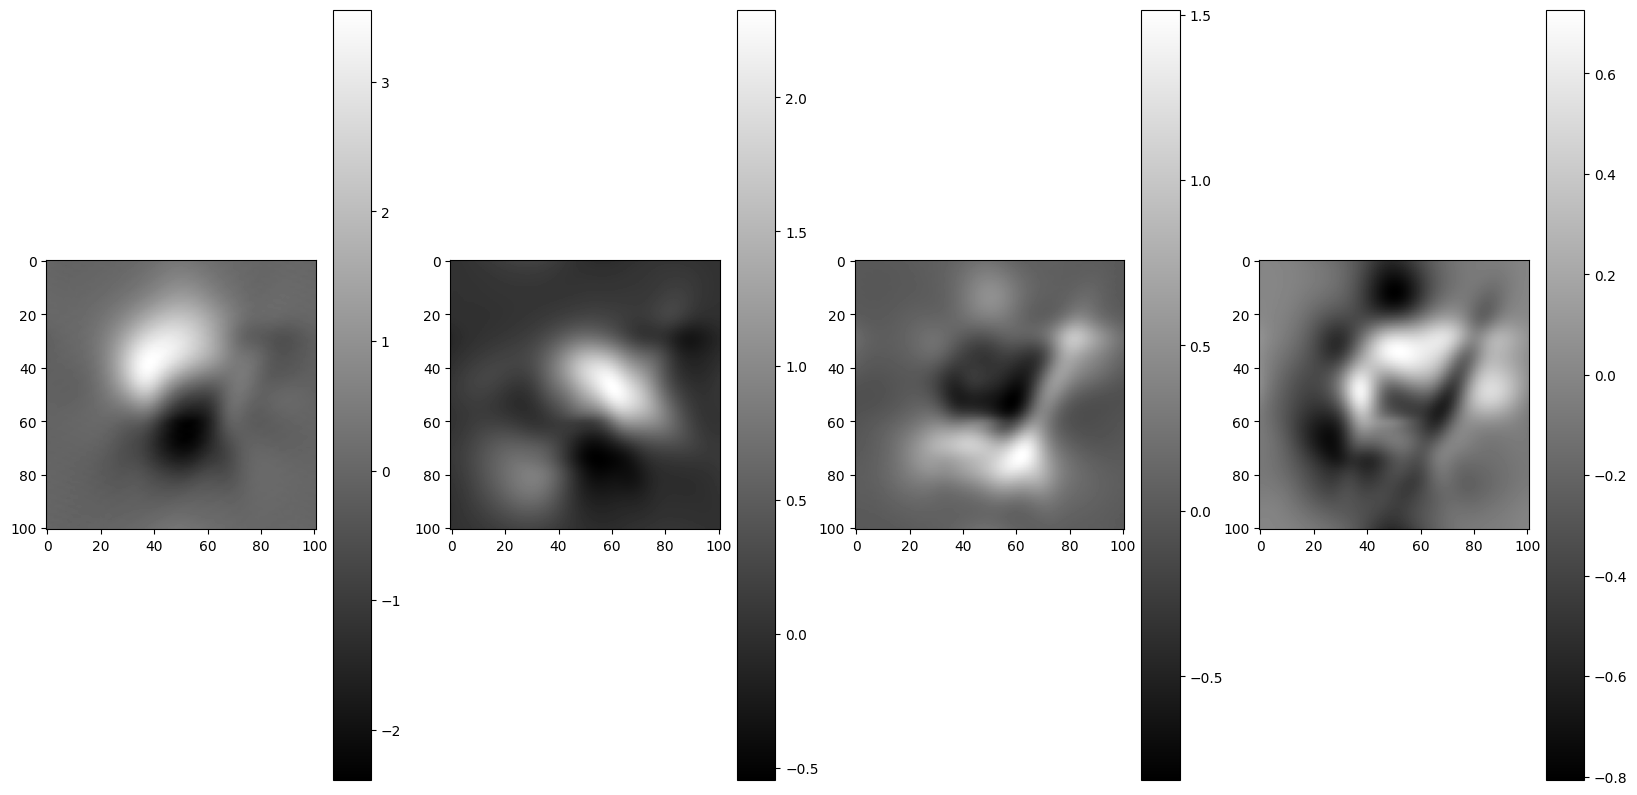

In [53]:
from nufft_plan import NufftPlan
d = torch.device('cuda:1')
plan = NufftPlan((img_size,)*3,batch_size = rank,gpu_device_id = d.index,gpu_method=1,gpu_sort = 0)
plan.setpts(torch.tensor(x['pts']).to(d))
vols = torch.tensor(x['vols']).to(d)
proj_vols = vol_forward(vols,plan)
p = aspire.image.Image(proj_vols.cpu().numpy())
p.show()

In [41]:

p = (torch.remainder(cds.pts_rot + torch.pi , 2 * torch.pi) - torch.pi) - torch.tensor(x['pts'])
#torch.tensor(x['pts']).shape
ind = torch.argmin(torch.norm(p.reshape((2000,-1)),dim=1))
aspire.utils.Rotation.from_matrix((sim.rotations[ind])).as_rotvec()



array([[-2.2380656 , -1.77634704,  1.03047276]])

In [54]:
b = fft_projs.asnumpy()[1].reshape(1,-1)
a = np.argmax(fft_projs.asnumpy()[1])
b[0,a]
x['pts'][:,a]

array([[-2.655451  , -2.6045566 , -2.553662  , ...,  2.553662  ,
         2.6045563 ,  2.655451  ],
       [ 2.8243315 ,  2.8459704 ,  2.8676102 , ..., -2.8676102 ,
        -2.8459704 , -2.8243315 ],
       [-0.5789449 , -0.6074326 , -0.63592005, ...,  0.63592005,
         0.6074326 ,  0.5789449 ]], dtype=float32)